# Assignment 3 Task 2 - ML Approach using SVM

In this task, team used a Support Vector Machine model to train on frames extracted from the UCF101 videos (scope limited to 15 selected classes from task 1) and tested and evaluated for acuraccy.


In [7]:
import pandas as pd
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

In [9]:
#Using the same test train split as task 1
train_df = pd.read_csv('./trainsplit15.csv')
test_df = pd.read_csv('./testsplit15.csv')

In [33]:
#Method to extract three frames from each video also change the size to 64x64
def extract_three_frames(video_path, size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        return None

    indices = [
        int(total_frames * 0.1),  # Start
        int(total_frames * 0.5),  # Middle
        int(total_frames * 0.9)   # End
    ]

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, size)
            frames.append(frame)

    cap.release()

    if len(frames) == 3:
        return frames
    return None

In [37]:
def three_frame_to_color_vector(frames):
    color_frames = [f.flatten() for f in frames]
    return np.concatenate(color_frames)  # Shape: (12288 * 3,) = 36864

In [41]:
def load_dataset_with_three_frames(df, feature_func, video_dir='./UCF101'):
    X, y = [], []

    for _, row in df.iterrows():
        video_file = row['filename']
        label = row['category']
        video_path = os.path.join(video_dir, video_file)

        frames = extract_three_frames(video_path)
        if frames:
            features = feature_func(frames)
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

Train shape: (1536, 36864)
Test shape: (385, 36864)
Accuracy: 0.7714285714285715


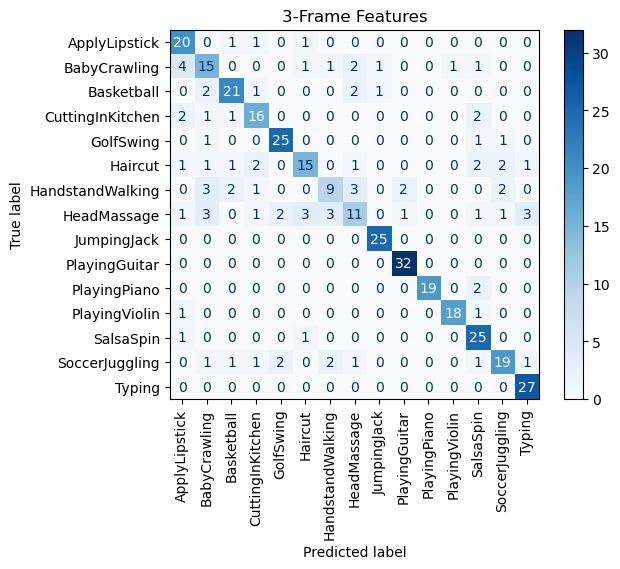

In [22]:
X_train, y_train = load_dataset_with_three_frames(train_df, three_frame_to_color_vector)
X_test, y_test = load_dataset_with_three_frames(test_df, three_frame_to_color_vector)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("3-Frame Features")
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV

In [26]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [28]:
grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.1min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=10.3min
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=10.9min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=37.4min
[CV] END .....................C=10, gamma=scale, kernel=poly; total time= 7.9min
[CV] END ......................C=10, gamma=auto, kernel=poly; total time= 2.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 9.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=10.8min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=12.4min
[CV] END .......................C=1, gamma=auto, kernel=poly; total time=34.9min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 6.9min
[CV] END .......................C=10, gamma=auto

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [30]:
print("Best parameters found:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

best_model = grid.best_estimator_

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8059895833333334


Test Accuracy with Best Model: 0.8675324675324675


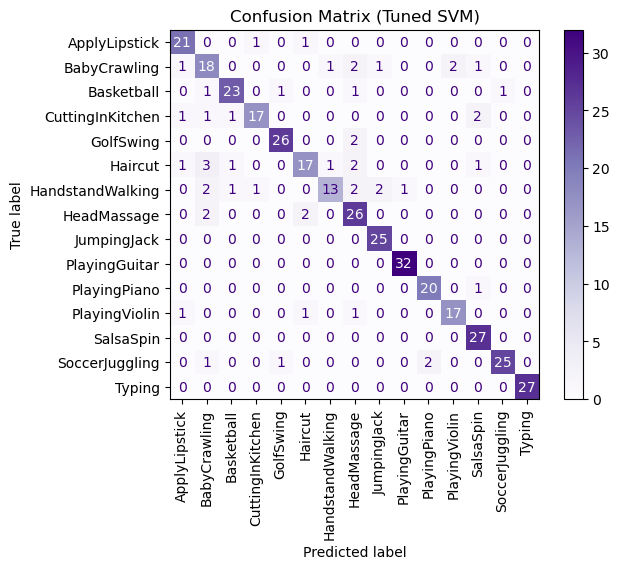

In [32]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Model:", accuracy)

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(xticks_rotation=90, cmap='Purples')
plt.title("Confusion Matrix (Tuned SVM)")
plt.show()

## Alternative Approaches in feature engineering


### Approach #1 - Histogram of Oriented Gradients

After computing HOG features on each video frame, the same SVM (with hyperparamteres from above) is tested and evaluated.

Done by Samsun Gulshan Sheik Dawood


In [15]:
import os
import numpy as np
from skimage.feature import hog
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def extract_hog_features(video_path, max_frames=30, frame_step=3, resize=(128,128)):
    cap = cv2.VideoCapture(video_path)
    feats = []
    count = 0
    while cap.isOpened() and count < max_frames * frame_step:
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_step == 0:
            gray = cv2.cvtColor(cv2.resize(frame, resize), cv2.COLOR_BGR2GRAY)
            hog_feat = hog(
                gray, pixels_per_cell=(16,16), cells_per_block=(2,2),
                block_norm='L2-Hys', feature_vector=True
            )
            feats.append(hog_feat)
        count += 1
    cap.release()
    return np.mean(feats, axis=0) if feats else np.zeros(3780)

def load_split(split_txt, data_root, label_map):
    X, y = [], []
    with open(split_txt, 'r') as f:
        for line in f:
            rel_path = line.strip().split()[0]  # only read the first column
            full_path = os.path.join(data_root, rel_path)
            class_name = rel_path.split('/')[0]
            if class_name not in label_map:
                continue
            feat = extract_hog_features(full_path)
            X.append(feat)
            y.append(label_map[class_name])
    return np.array(X), np.array(y)

Test accuracy: 51.01%


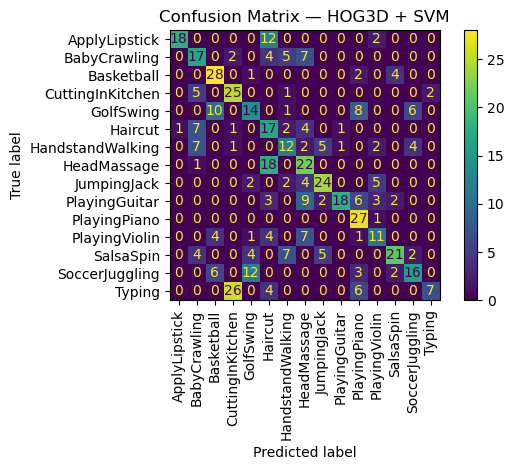

In [3]:
# --- Select 15-classes ---
selected_classes = [
    'ApplyLipstick', 'BabyCrawling', 'Basketball', 'CuttingInKitchen', 'GolfSwing',
    'Haircut', 'HandstandWalking', 'HeadMassage', 'JumpingJack',
    'PlayingGuitar', 'PlayingPiano', 'PlayingViolin',
    'SalsaSpin', 'SoccerJuggling', 'Typing'
]

label_map = {cls: idx for idx, cls in enumerate(selected_classes)}

# --- Paths ---
data_root = 'UCF-101'
train_txt = 'ucfTrainTestlist/trainlist01.txt'
test_txt  = 'ucfTrainTestlist/testlist01.txt'


# --- Load features ---
X_train, y_train = load_split(train_txt, data_root, label_map)
X_test, y_test = load_split(test_txt, data_root, label_map)

# --- Normalize features ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Train SVM with best parameters ---
clf = SVC(kernel='rbf', C=10, gamma='scale')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# --- Evaluate ---
print(f"Test accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix — HOG3D + SVM")
plt.tight_layout()
plt.show()

## OPTIONAL - Alternative Approaches


### Approach #1 - Using Random Forest

Done by Harrison Stefanidis

#### Task 1.1 - Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#### Task 1.2 - Define Frame Extraction Functions

In [7]:
def extract_middle_frame(video_path, size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
    ret, frame = cap.read()
    cap.release()

    if ret:
        frame = cv2.resize(frame, size)
        return frame
    return None

def frame_to_vector(frame):
    return frame.flatten()

#### Task 1.3 - Load CSV Files for Train/Test Split

In [29]:
train_df = pd.read_csv('./trainsplit15.csv')
test_df = pd.read_csv('./testsplit15.csv')

#### Task 1.4 - Load Dataset and Extract Features

In [43]:
X_train, y_train = load_dataset_with_three_frames(train_df, three_frame_to_color_vector)
X_test, y_test = load_dataset_with_three_frames(test_df, three_frame_to_color_vector)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (1536, 36864)
Test set shape: (385, 36864)


#### Task 1.5 - Basic Random Forest Training

Random Forest Accuracy: 0.8545


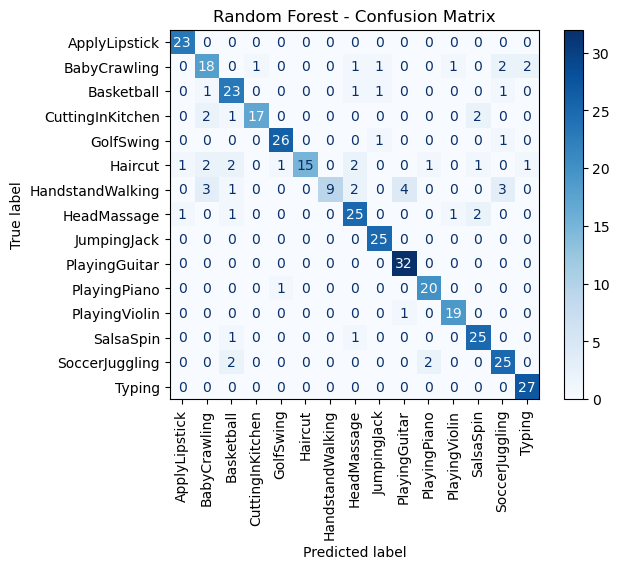

In [44]:
# Train a basic Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred = rf_clf.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

#### Task 1.6 - Hyperparameter Tuning

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters (Fast Version): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF Accuracy (Fast Grid): 0.8571


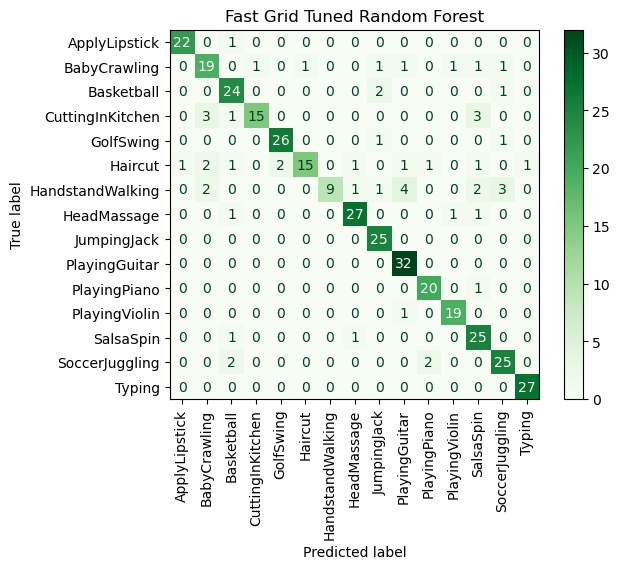

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Efficient tuning parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

# Quick GridSearch
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best result
best_params = grid_search.best_params_
print("Best Parameters (Fast Version):", best_params)

# Retrain on full training data
final_rf_model = RandomForestClassifier(**best_params, random_state=42)
final_rf_model.fit(X_train, y_train)

# Evaluate
y_pred_best = final_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Tuned RF Accuracy (Fast Grid): {best_accuracy:.4f}")

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best, labels=np.unique(y_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=np.unique(y_test))
disp_best.plot(xticks_rotation=90, cmap='Greens')
plt.title("Fast Grid Tuned Random Forest")
plt.show() 

### Approach #2 - Training on STIP features of the videos on SVM model

Done by Harrison Stefanidis

#### Task 1 - Set Up and Load Train/Test Splits

In [1]:
import pandas as pd

# Load the pre-defined 15-class train/test splits
train_df = pd.read_csv('./trainsplit15.csv')
test_df = pd.read_csv('./testsplit15.csv')

# Display sample rows
print("Train Split Example:")
print(train_df.head())
print("\nTest Split Example:")
print(test_df.head())

Train Split Example:
   class                        filename          category
0     25  v_CuttingInKitchen_g22_c04.avi  CuttingInKitchen
1     67     v_PlayingViolin_g18_c03.avi     PlayingViolin
2     95            v_Typing_g01_c06.avi            Typing
3     77         v_SalsaSpin_g24_c01.avi         SalsaSpin
4     33         v_GolfSwing_g21_c05.avi         GolfSwing

Test Split Example:
   class                    filename      category
0     39   v_HeadMassage_g23_c05.avi   HeadMassage
1     47   v_JumpingJack_g25_c04.avi   JumpingJack
2     39   v_HeadMassage_g19_c01.avi   HeadMassage
3      8    v_Basketball_g18_c04.avi    Basketball
4     64  v_PlayingPiano_g16_c07.avi  PlayingPiano


#### Task 2 - Define Functions to Load STIP Features

In [2]:
import os
import re
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Extract averaged feature vectors for each video from a STIP file
def parse_stip_class_file_by_video(file_path):
    stip_by_video = defaultdict(list)
    current_video = None

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("# UCF"):
                match = re.search(r'v_(.+?)$', line)
                if match:
                    current_video = match.group(1)
            elif not line or line.startswith("#"):
                continue
            else:
                if current_video:
                    try:
                        vec = np.array([float(x) for x in line.split()])
                        stip_by_video[current_video].append(vec)
                    except ValueError:
                        continue

    # Average vectors per video
    video_feature_map = {
        vid: np.mean(vecs, axis=0)
        for vid, vecs in stip_by_video.items() if vecs
    }
    return video_feature_map

# Load STIP vectors from all text files in given folders
def load_all_stip_vectors(stip_dirs=['./STIP1', './STIP2']):
    all_video_features = {}

    for folder in stip_dirs:
        print(f"\nProcessing folder: {folder}")
        files = [f for f in os.listdir(folder) if f.endswith('.txt')]
        folder_features = {}

        for fname in tqdm(files, desc="Parsing files", leave=False):
            path = os.path.join(folder, fname)
            video_map = parse_stip_class_file_by_video(path)
            folder_features.update(video_map)

        print(f"Finished {folder}: {len(folder_features)} videos parsed")
        all_video_features.update(folder_features)

    print(f"\nTotal videos loaded: {len(all_video_features)}")
    return all_video_features

# Create feature and label arrays from the video feature map and dataframe
def build_stip_dataset_from_video_map(df, video_feature_map):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Matching features"):
        video_id = os.path.splitext(os.path.basename(row['filename']))[0].replace("v_", "")
        label = row['category']
        if video_id in video_feature_map:
            X.append(video_feature_map[video_id])
            y.append(label)
    return np.array(X), np.array(y)

#### Task 3 - Load STIP Feature Matrices

In [3]:
# Load STIP features for both train and test sets
stip_video_map = load_all_stip_vectors()

X_train_stip, y_train_stip = build_stip_dataset_from_video_map(train_df, stip_video_map)
X_test_stip, y_test_stip = build_stip_dataset_from_video_map(test_df, stip_video_map)

# Confirm the shapes of the datasets
print("STIP Train shape:", X_train_stip.shape)
print("STIP Test shape:", X_test_stip.shape)


Processing folder: ./STIP1


Finished ./STIP1: 6469 videos parsed

Processing folder: ./STIP2


Finished ./STIP2: 6844 videos parsed

Total videos loaded: 13313


Matching features: 100%|██████████| 385/385 [00:00<00:00, 21447.54it/s]

STIP Train shape: (1535, 171)
STIP Test shape: (384, 171)


#### Task 4 - Train/Evaluate an SVM with STIP Features

STIP Feature Accuracy (Linear SVM): 0.65625


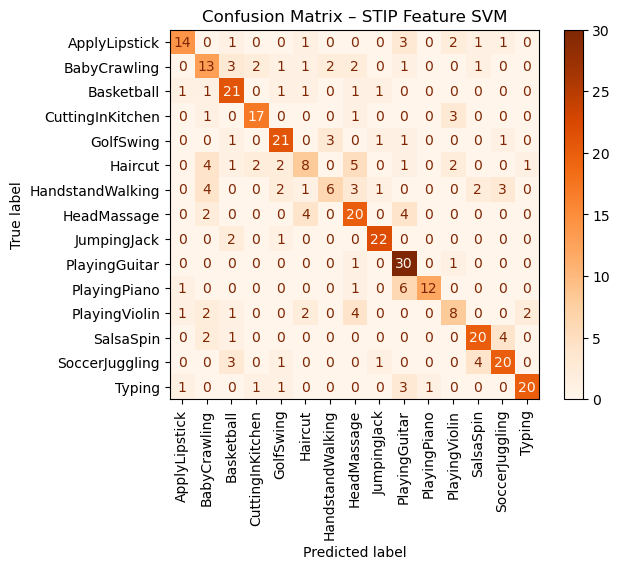

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create and train a linear SVM
model_stip = SVC(kernel='linear')
model_stip.fit(X_train_stip, y_train_stip)

# Predict on test set
y_pred_stip = model_stip.predict(X_test_stip)

# Accuracy score
acc_stip = accuracy_score(y_test_stip, y_pred_stip)
print("STIP Feature Accuracy (Linear SVM):", acc_stip)

# Confusion matrix
cm_stip = confusion_matrix(y_test_stip, y_pred_stip, labels=np.unique(y_test_stip))
disp_stip = ConfusionMatrixDisplay(confusion_matrix=cm_stip, display_labels=np.unique(y_test_stip))
disp_stip.plot(xticks_rotation=90, cmap='Oranges')
plt.title("Confusion Matrix – STIP Feature SVM")
plt.show()

#### Task 5 - Hyperparameter Tuning

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best STIP parameters: {'C': 100, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validated accuracy: 0.7830618892508143
STIP Accuracy (Tuned + PCA): 0.8541666666666666
                  precision    recall  f1-score   support

   ApplyLipstick       0.78      0.91      0.84        23
    BabyCrawling       0.71      0.85      0.77        26
      Basketball       0.83      0.93      0.88        27
CuttingInKitchen       0.90      0.86      0.88        22
       GolfSwing       0.89      0.89      0.89        28
         Haircut       0.73      0.62      0.67        26
HandstandWalking       0.83      0.45      0.59        22
     HeadMassage       0.71      0.83      0.77        30
     JumpingJack       0.96      1.00      0.98        25
   PlayingGuitar       0.97      0.97      0.97        32
    PlayingPiano       1.00      0.80      0.89        20
   PlayingViolin       0.70      0.70      0.70        

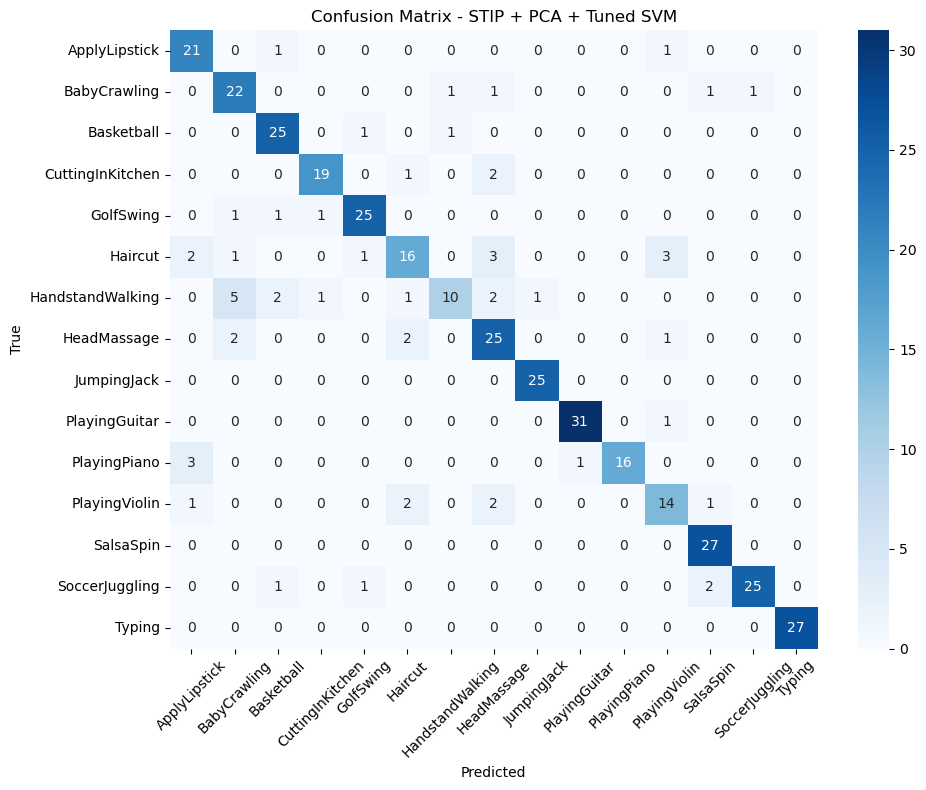

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_stip)
X_test_scaled = scaler.transform(X_test_stip)

# Apply PCA
pca = PCA(n_components=75, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid_stip = {
    'C': [0.1, 1, 10, 50, 100, 500],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'class_weight': [None, 'balanced']
}

# Run grid search
grid_stip = GridSearchCV(SVC(), param_grid_stip, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
grid_stip.fit(X_train_pca, y_train_stip)

# Report best parameters
print("Best STIP parameters:", grid_stip.best_params_)
print("Best cross-validated accuracy:", grid_stip.best_score_)

# Predict with best model
best_model_stip = grid_stip.best_estimator_
y_pred_best_stip = best_model_stip.predict(X_test_pca)
acc_best_stip = accuracy_score(y_test_stip, y_pred_best_stip)
print("STIP Accuracy (Tuned + PCA):", acc_best_stip)

# Classification report
print(classification_report(y_test_stip, y_pred_best_stip))

# Confusion matrix
cm = confusion_matrix(y_test_stip, y_pred_best_stip)
labels = np.unique(y_test_stip)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - STIP + PCA + Tuned SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Task 6 - Comparison of Feature Extraction Methods

#### Final Comparison of Feature Extraction Methods

#### Method: `three_frame_to_color_vector`
- Extracts three representative frames (start, middle, end) from each video.
- Each frame is resized, flattened, and concatenated into a single long vector.
- Captures appearance and color, but ignores motion.
- **Accuracy**: `0.8675`

#### Method: `STIP`
- Loads motion-based descriptors from `.txt` files in the STIP1 and STIP2 directories.
- Extracted features include HOG and HOF, capturing motion and spatial-temporal dynamics.
- Averages all rows in each class file into one fixed-length feature vector.
- **Accuracy**: `0.8541`

---

### Conclusion
The three-frame color vector method outperformed the STIP-based approach, achieving higher classification accuracy. This suggests that, for the selected 15 action classes, appearance information was more discriminative than motion features alone. While STIP captures rich temporal and motion cues, its aggregation into a single vector may have caused a loss of nuance across diverse actions. Nonetheless, STIP remains valuable for motion-intensive tasks, whereas the three-frame method provides a simpler, faster baseline with strong results.